# Create a notebook environment

## From PowerShell

```pwsh
# Create and enter a new Python virtual environment for the notebook
mkdir pynotebook
cd pynotebook
python -m venv --upgrade-deps .venv
.\.venv\Scripts\activate.ps1

# Install the notebook dependencies
pip install jupyter seaborn
```

# Open the notebook in VS Code

1. Install the Python notebook extension for VS Code named [**Jupyter**](https://marketplace.visualstudio.com/items?itemName=ms-toolsai.jupyter)
   * View raw data with [**Data Wrangler**](https://marketplace.visualstudio.com/items?itemName=ms-toolsai.datawrangler)
   * Render diagrams with [**Markdown Preview Mermaid**](https://marketplace.visualstudio.com/items?itemName=bierner.markdown-mermaid)
1. Copy this file to the `pynotebook` folder
1. Copy the csv files to a subfolder named `data`
1. Open the `pynotebook` folder in VS Code and open this file
1. Select the new Python `.venv` as the **Jupyter kernel** for this file
   * More details in the VS Code [**tutorial for data science**](https://code.visualstudio.com/docs/datascience/jupyter-notebooks#_create-or-open-a-jupyter-notebook)

# Measurement setup

## Electrical connections

1. Connect a **variable power supply** _(Vref)_ to the QT Py S3
   * 🟥 Positive terminal to every analog input channel _(AIx)_
   * ⬛ Negative terminal to the ground pin _(Ground)_
1. Measure the power supply voltage with a **DMM**
1. Set the voltage to a reference value
1. Collect voltage measurements from the QT Py S3 analog channels

See [**characterization_setup.md**](./characterization_setup.md) for a diagram.

## Measurement pseudo-code

1. Take `N` samples from each channel and average them
1. Sweep `N` across a decade-spaced series
1. Repeat the test `K` times
1. Add a data entry containing
   * an identifier for QT Py S3
   * the analog input channel
   * the number of samples averaged
   * the resulting ADC code

```py
test_runs = 30
samples_to_average_list = [1, 10, 20, 50, 100, 200, 500, 1000, 2000]

for _ in range(test_runs):
    for samples_to_average in samples_to_average_list:
        for analog_input in sorted(analog_input_channels):
            average_channel_code = take_n(analog_input, samples_to_average)
```


# Begin the notebook

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so

import IPython.display as idisplay
import matplotlib.ticker

readable_format = matplotlib.ticker.EngFormatter()

def display_markdown(markdown_string):
    idisplay.display_markdown(markdown_string, raw=True)

# Load the data files

In [40]:
sns.set_theme()

characterization_files = [
    "data\\u1_longform_0150.34mV_ref.csv",
    "data\\u2_longform_0150.34mV_ref.csv",
    "data\\u1_longform_01.6484V_ref.csv",
    "data\\u2_longform_01.6484V_ref.csv",
    "data\\u1_longform_02.9997V_ref.csv",
    "data\\u2_longform_02.9997V_ref.csv",
]
all_frames = []
for data_file in characterization_files:
    data = pd.read_csv(
        data_file,
    )
    all_frames.append(data)

all_data = pd.concat(all_frames)
all_data = all_data.reset_index(drop=True)
display(all_data)

,QTPy channel,Samples averaged,ADC code,QTPy identifier
0,AI0,1,3197.0,24ec4a1dd628
1,AI1,1,2959.0,24ec4a1dd628
2,AI2,1,2522.0,24ec4a1dd628
3,AI3,1,2959.0,24ec4a1dd628
4,AI4,1,2522.0,24ec4a1dd628
...,...,...,...,...
12955,AI3,2000,59622.7,48ca43576cdc
12956,AI4,2000,59608.9,48ca43576cdc
12957,AI5,2000,59617.3,48ca43576cdc
12958,AI6,2000,59615.1,48ca43576cdc


# Ideal scaling

In [41]:
volts_per_LSB = 3.3 / 2**16
oneLSB_scale_string = f"1 LSB == `{readable_format(volts_per_LSB)}V` _(ideal)_"
display_markdown(f"## {oneLSB_scale_string}")

## 1 LSB == `50.354 µV` _(ideal)_

# Add a new column named `Reference voltage`

In [42]:
def add_reference_voltage(df):
    bin_labels = ["low", "medium", "high"]
    bin_count = len(bin_labels)
    out, bins = pd.cut(x=df["ADC code"], bins=bin_count, labels=bin_labels, retbins=True)
    df["Reference voltage"] = out
    return df

In [43]:
def add_reference_voltage_explicit(df, reference_level_partitions):
    increasing_order = sorted(reference_level_partitions.keys())
    for lower_bound in increasing_order:
        bin_name = reference_level_partitions[lower_bound]
        row_is_above_threshhold = df["ADC code"] > lower_bound
        df.loc[row_is_above_threshhold, "Reference voltage"] = bin_name
    return df

In [44]:
reference_level_partitions = {
    0: "low",
    20000: "mid",
    45000: "high",
}
all_data.pipe(add_reference_voltage_explicit, reference_level_partitions)
display(all_data[["ADC code", "Reference voltage"]].sample(10))

,ADC code,Reference voltage
7957,32407.90,mid
113,2972.98,low
10277,59449.50,high
10598,59409.80,high
11508,59577.50,high
10794,59451.20,high
4144,2939.65,low
4664,32844.40,mid
10721,59693.40,high
6555,32489.00,mid


# Add a new column named `ADC instance`

![QT Py S3 pinout](https://cdn-learn.adafruit.com/assets/assets/000/117/412/original/adafruit_products_Adafruit_QT_Py_ESP32-S3_Pinout_updated.png)

In [45]:
def add_adc_instance(df):
    # https://github.com/adafruit/Adafruit-QT-Py-ESP32-S3-PCB/blob/main/Adafruit_QT_Py_ESP32-S3_Pinout.pdf
    adc2_channel_names = ["AI0", "AI1", "AI7"]
    adc2_channels = df["QTPy channel"].isin(adc2_channel_names)
    df["ADC instance"] = np.where(adc2_channels, "ADC2", "ADC1")
    return df

In [46]:
all_data.pipe(add_adc_instance)
all_data[["QTPy channel", "ADC instance"]].head(8)

,QTPy channel,ADC instance
0,AI0,ADC2
1,AI1,ADC2
2,AI2,ADC1
3,AI3,ADC1
4,AI4,ADC1
5,AI5,ADC1
6,AI6,ADC1
7,AI7,ADC2


# Inspect a subset

In [47]:
subset_filter = (all_data["QTPy identifier"] == "24ec4a1dd628") & (all_data["Reference voltage"] == "low")

data_subset = all_data
#data_subset = all_data[subset_filter]

# Plot the data

<Axes: >

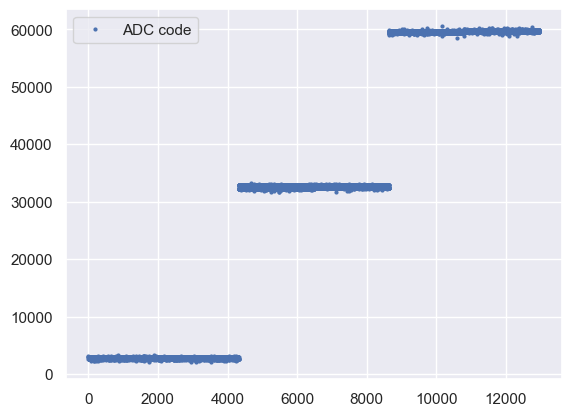

In [48]:
data_subset[["ADC code"]].plot.line(style="o", markersize=2)

# Color by channel name

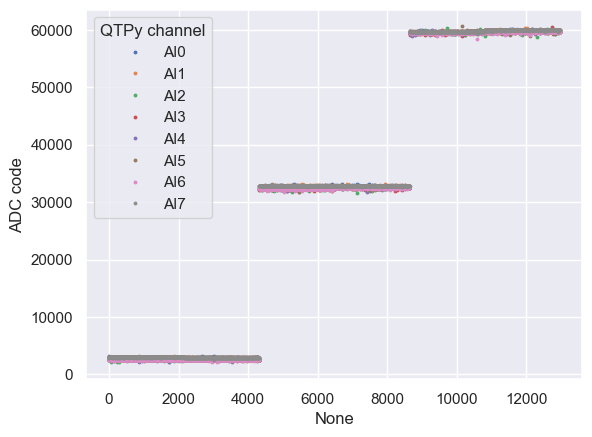

In [49]:
dots = sns.lineplot(data=data_subset, x=data_subset.index, y="ADC code", hue="QTPy channel", linestyle="", marker="o", markersize=2, markeredgecolor=None)

# Plot by samples averaged

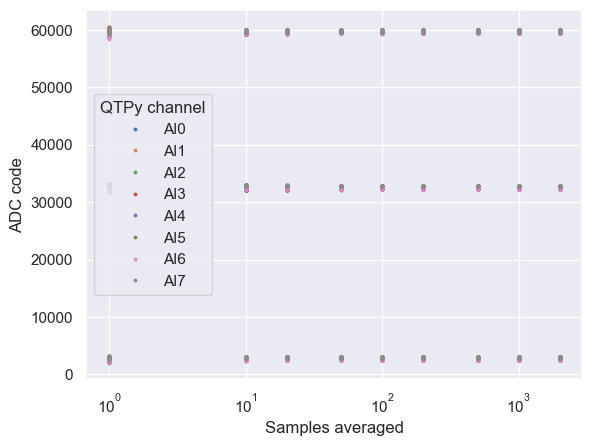

In [50]:
dots2 = sns.lineplot(
    data=data_subset, x="Samples averaged", y="ADC code", hue="QTPy channel",
    linestyle="", marker="o", markersize=2, markeredgecolor=None, estimator=None
)
dots2.set_xscale("log")

# Inspect ADC resolution

## Plot only single-sample data

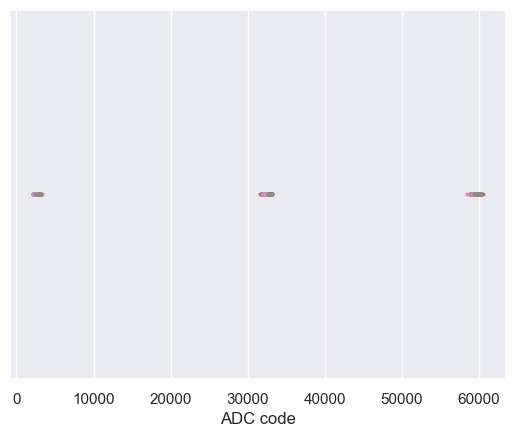

In [51]:
dots_filtered = data_subset[data_subset["Samples averaged"] < 10]
dots3 = sns.lineplot(
    data=dots_filtered, x="ADC code", y="Samples averaged", hue="QTPy channel",
    linestyle="", marker="o", markersize=2, markeredgecolor=None, estimator=None, legend=False
)
dots3.yaxis.set_visible(False)

## How far are ADC codes from each other?

In [52]:
ordered_codes = dots_filtered.sort_values("ADC code")
ordered_codes["code diff"] = ordered_codes["ADC code"].diff()
display(ordered_codes[["ADC code", "code diff"]])

,ADC code,code diff
1732,2085.0,NaN
3102,2105.0,20.0
2958,2164.0,59.0
3532,2164.0,0.0
290,2184.0,20.0
...,...,...
12025,60232.0,40.0
11953,60272.0,40.0
9722,60292.0,20.0
12747,60411.0,119.0


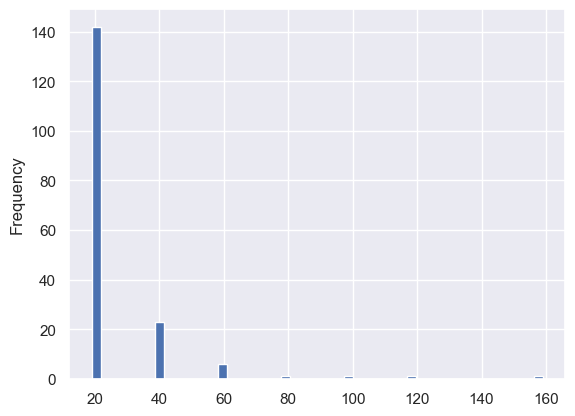

In [53]:

code_filter = (ordered_codes["code diff"] > 0) & (ordered_codes["code diff"] < 200)
code_diff_hists = ordered_codes[code_filter]["code diff"].dropna().plot.hist(bins=50)

### Overlap count

In [54]:
same_code_difference = 0
overlap_count = ordered_codes["code diff"].value_counts()[same_code_difference]
display_markdown(f"## **{overlap_count}** samples have **same** ADC code")

## **1261** samples have **same** ADC code

## Measured ADC resolution is 1 mV

In [55]:
ideal_scale_string = f"20 LSB == `{readable_format(volts_per_LSB * 20)}V` _(ideal)_"
display_markdown(f"## {ideal_scale_string}")

## 20 LSB == `1.00708 mV` _(ideal)_

# Plot each channel in its own graph

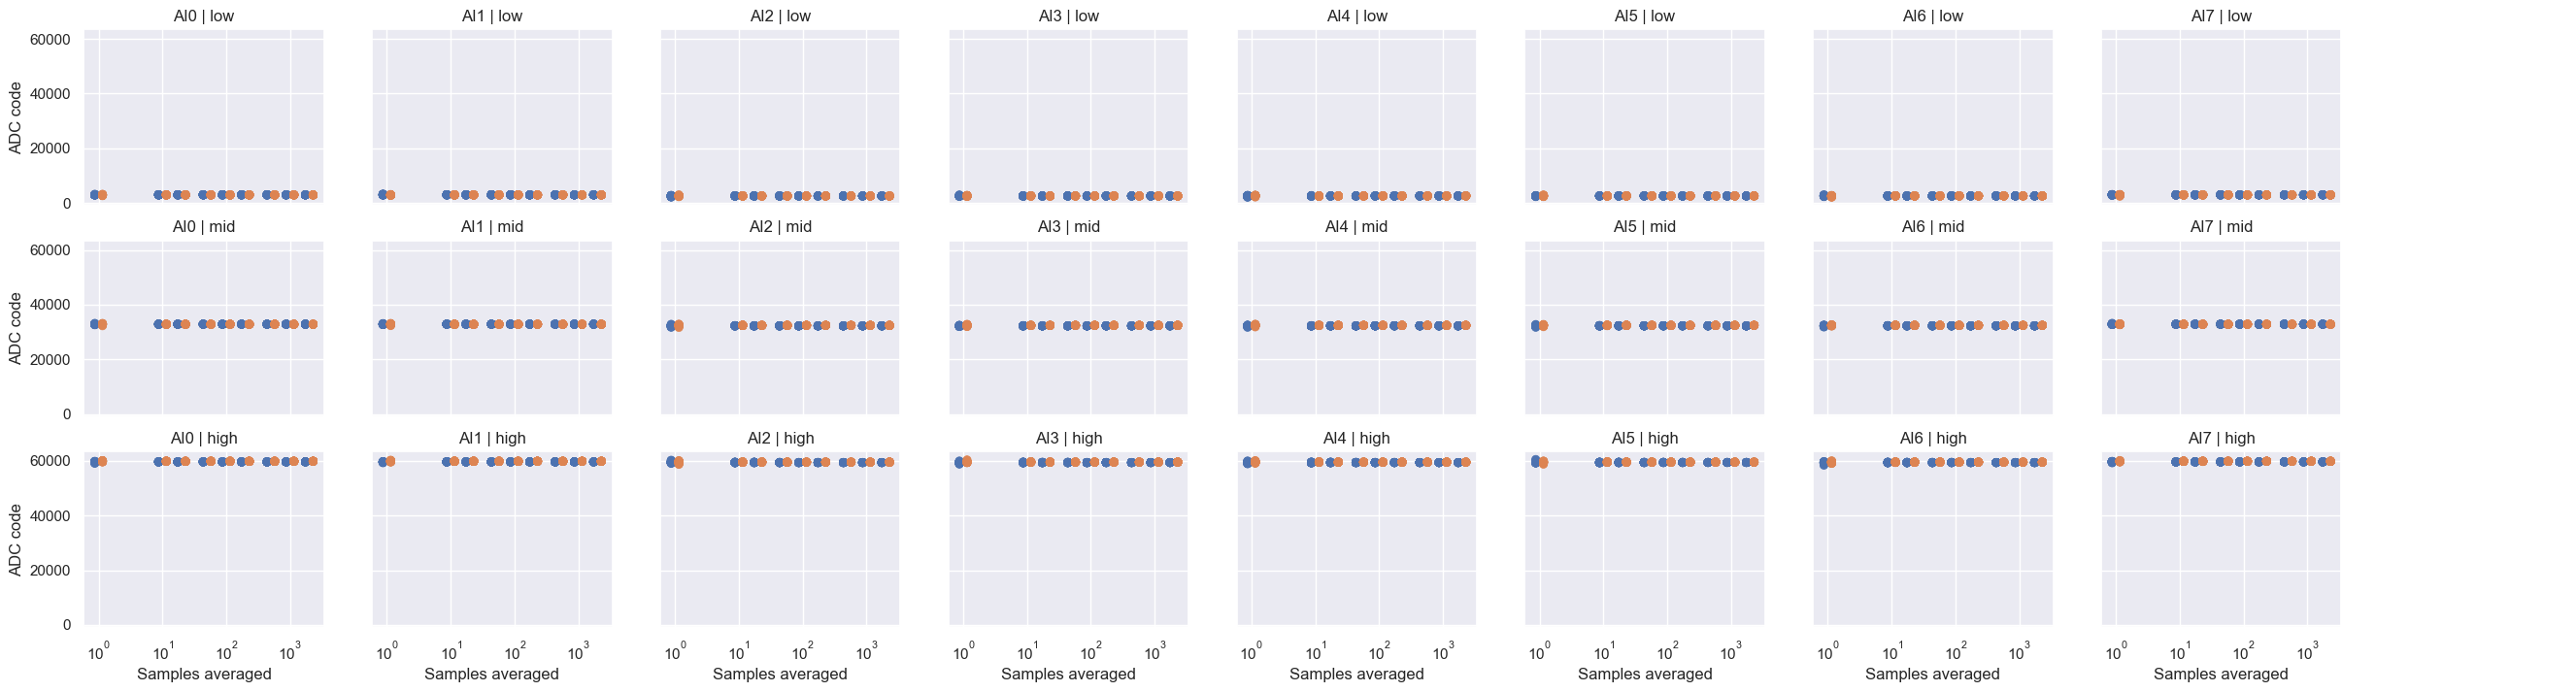

In [56]:
figure = plt.figure(figsize=(30, 8))

plot = (
    so.Plot(
        data_subset,
        x="Samples averaged",
        y="ADC code",
        color="QTPy identifier",
    )
    .facet(row="Reference voltage", col="QTPy channel")
    .share(x=True, y=True)
    .add(so.Dot(), so.Dodge())
    .scale(x="log")
    .on(figure)
)

plot.show()

# Does the QTPy ADC influence the measurement?

In [57]:
group1_channels = data_subset["QTPy channel"].isin(["AI2", "AI3", "AI4", "AI5", "AI6"])
group1_frame = data_subset[group1_channels]

group2_channels = data_subset["QTPy channel"].isin(["AI0", "AI1", "AI7"])
group2_frame = data_subset[group2_channels]

display(group1_frame.head())
display(group2_frame.head())

,QTPy channel,Samples averaged,ADC code,QTPy identifier,Reference voltage,ADC instance
2,AI2,1,2522.0,24ec4a1dd628,low,ADC1
3,AI3,1,2959.0,24ec4a1dd628,low,ADC1
4,AI4,1,2522.0,24ec4a1dd628,low,ADC1
5,AI5,1,2601.0,24ec4a1dd628,low,ADC1
6,AI6,1,2581.0,24ec4a1dd628,low,ADC1


,QTPy channel,Samples averaged,ADC code,QTPy identifier,Reference voltage,ADC instance
0,AI0,1,3197.0,24ec4a1dd628,low,ADC2
1,AI1,1,2959.0,24ec4a1dd628,low,ADC2
7,AI7,1,2959.0,24ec4a1dd628,low,ADC2
8,AI0,10,2978.7,24ec4a1dd628,low,ADC2
9,AI1,10,2992.4,24ec4a1dd628,low,ADC2


## Plot each ADC instance on its own graph

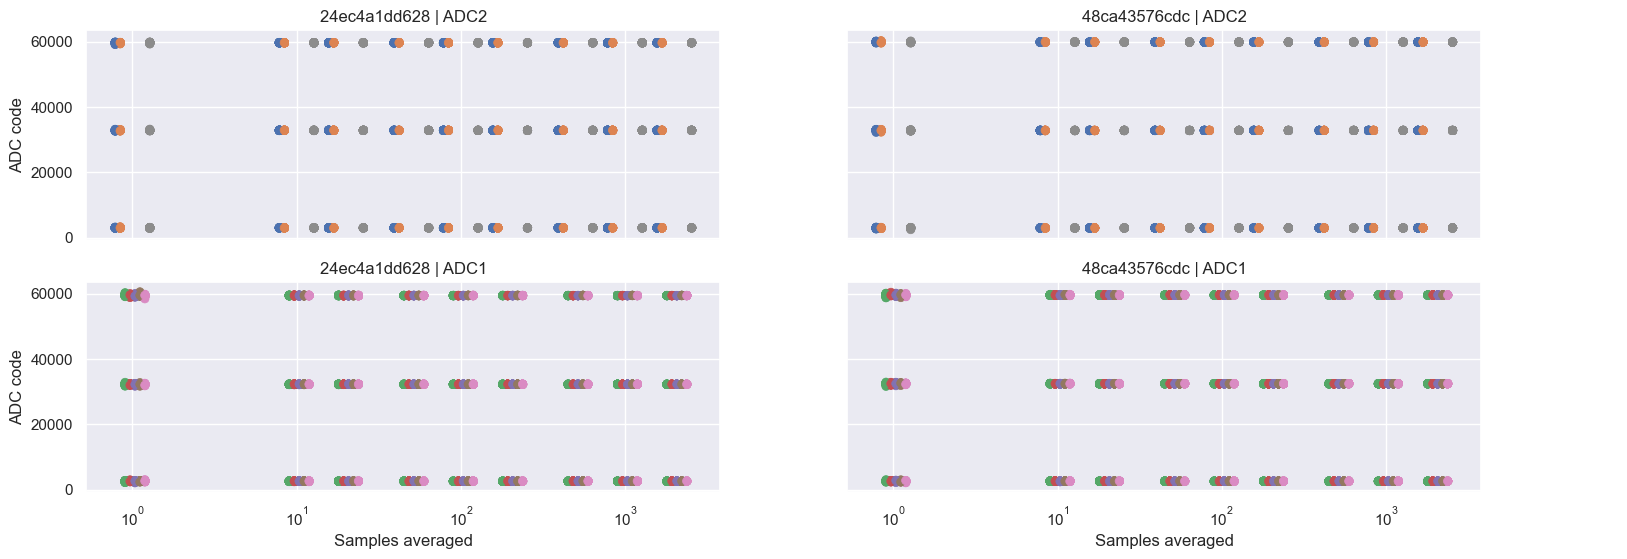

In [58]:
figure2 = plt.figure(figsize=(18,6))

plot2 = (
    so.Plot(
        data_subset,
        x="Samples averaged",
        y="ADC code",
        color="QTPy channel",
    )
    .facet(row="ADC instance", col="QTPy identifier")
    .add(so.Dot(), so.Dodge())
    .scale(x="log")
    .on(figure2)
)

plot2.show()

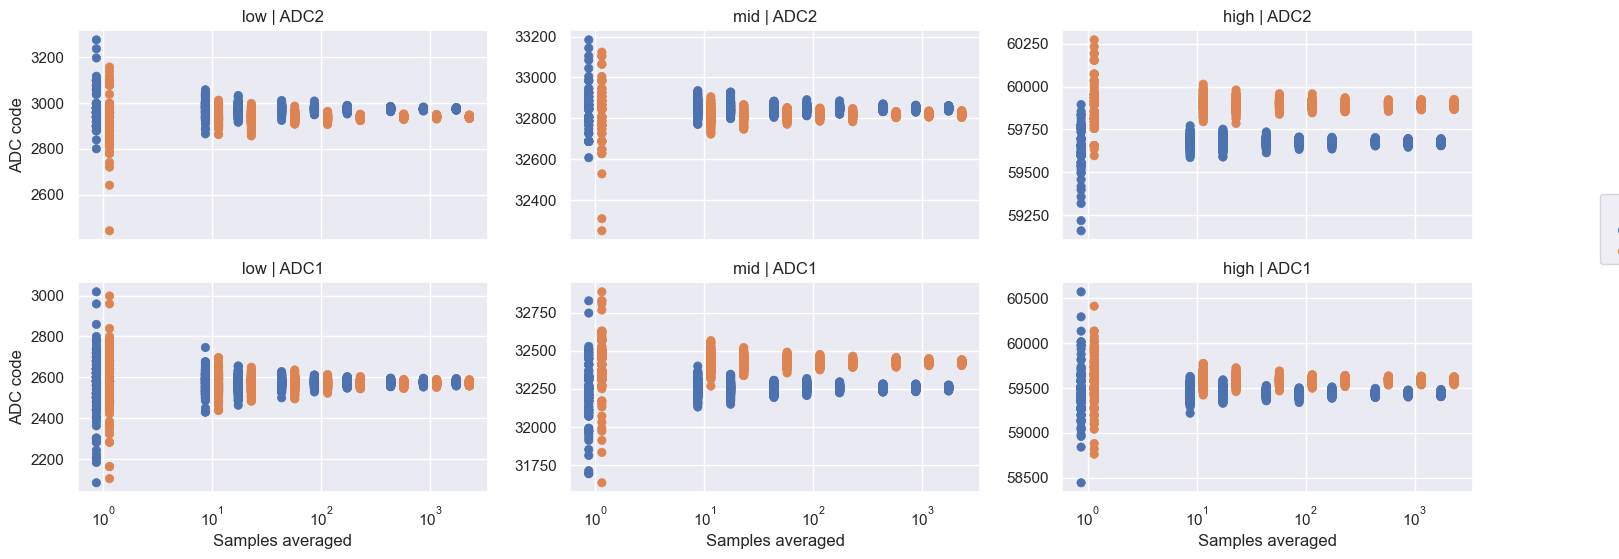

In [59]:
f = plt.figure(figsize=(18,6))

p = (
    so.Plot(
        data_subset,
        x="Samples averaged",
        y="ADC code",
        color="QTPy identifier",
    )
    .facet(row="ADC instance", col="Reference voltage")
    .share(x=True, y=False)
    .add(so.Dot(), so.Dodge())
    .scale(x="log")
    .on(f)
)

p.show()

## Plot statistics about each ADC instance

In [60]:
display_markdown(f"### {oneLSB_scale_string}")
display_markdown(f"### {ideal_scale_string}")

### 1 LSB == `50.354 µV` _(ideal)_

### 20 LSB == `1.00708 mV` _(ideal)_

In [61]:
by_qtpy_adc_vref = data_subset.groupby(["QTPy identifier", "ADC instance", "Reference voltage"])
display(by_qtpy_adc_vref.size())

QTPy identifier  ADC instance  Reference voltage
24ec4a1dd628     ADC1          high                 1350
                               low                  1350
                               mid                  1350
                 ADC2          high                  810
                               low                   810
                               mid                   810
48ca43576cdc     ADC1          high                 1350
                               low                  1350
                               mid                  1350
                 ADC2          high                  810
                               low                   810
                               mid                   810
dtype: int64

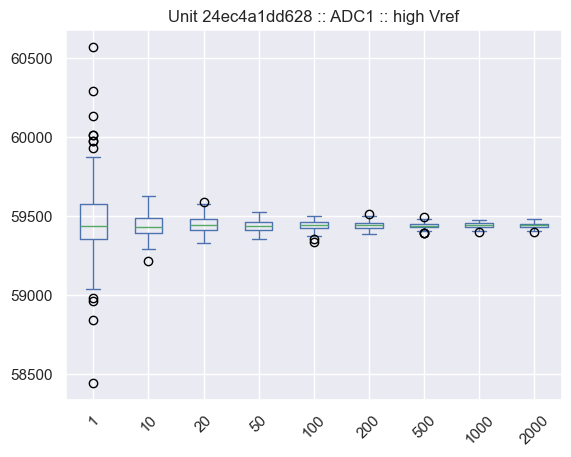

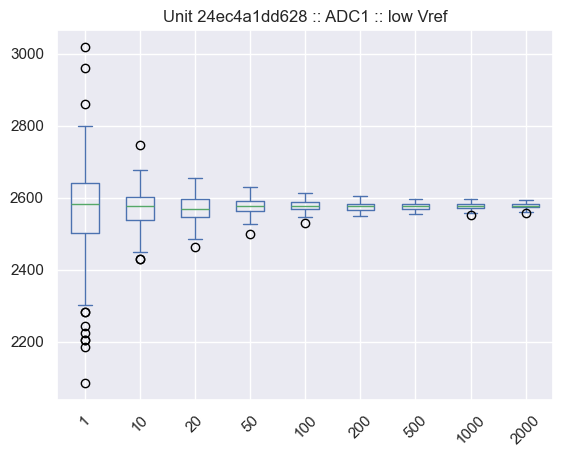

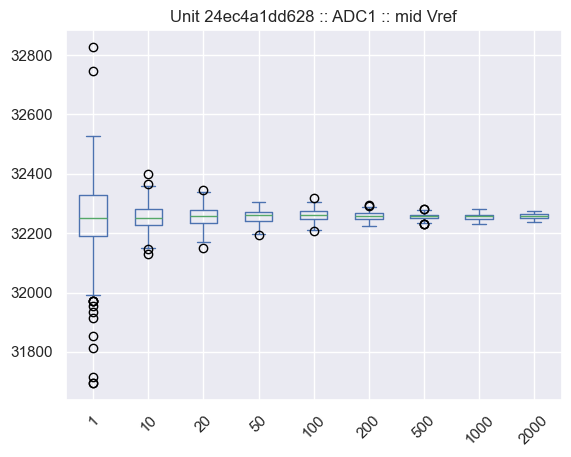

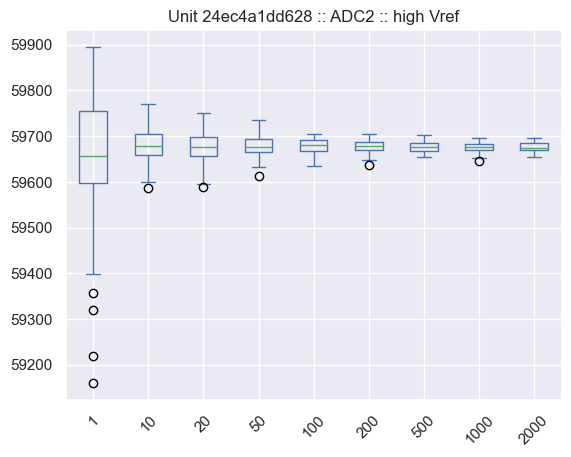

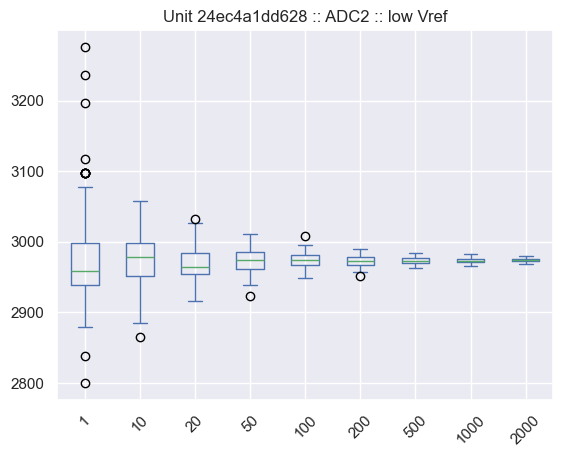

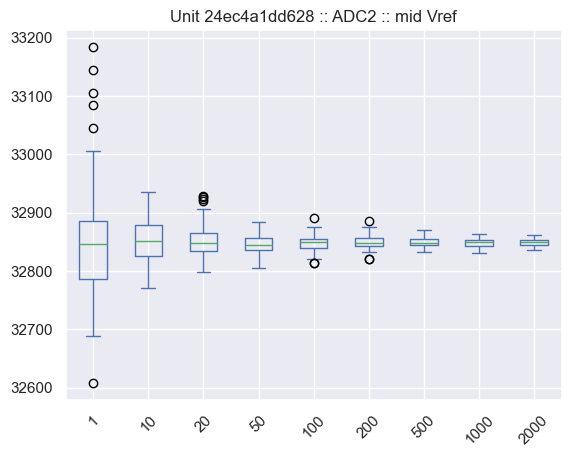

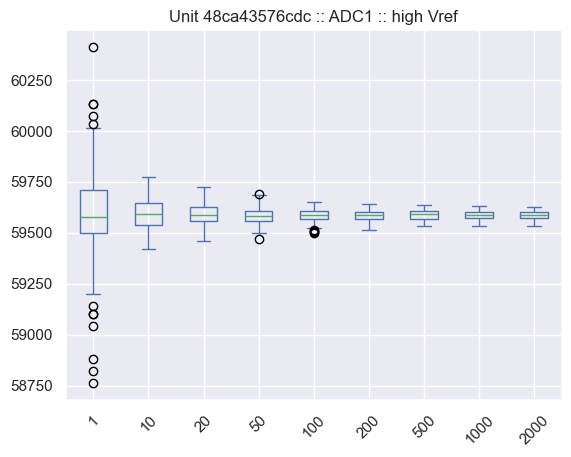

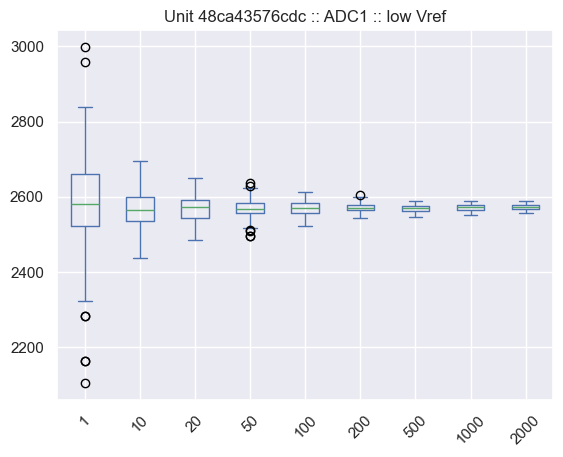

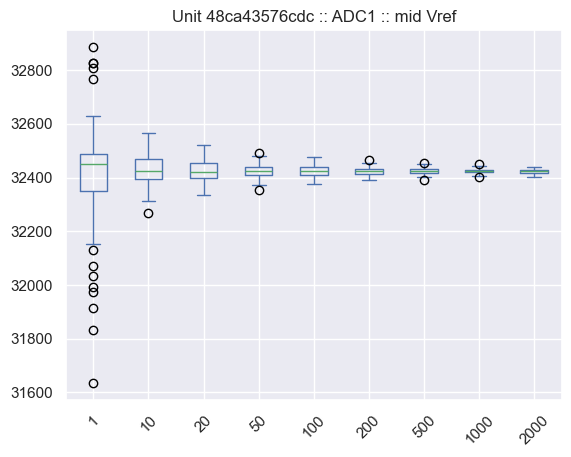

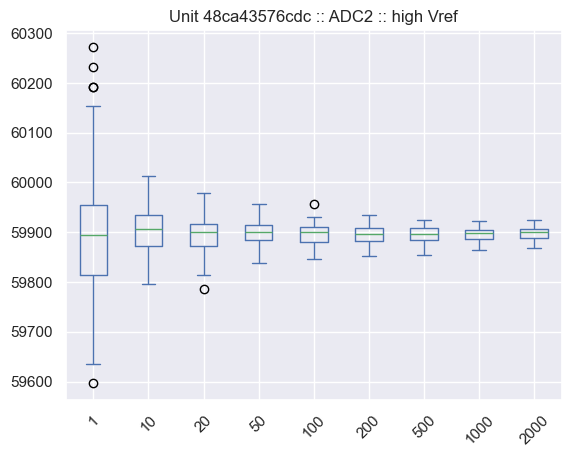

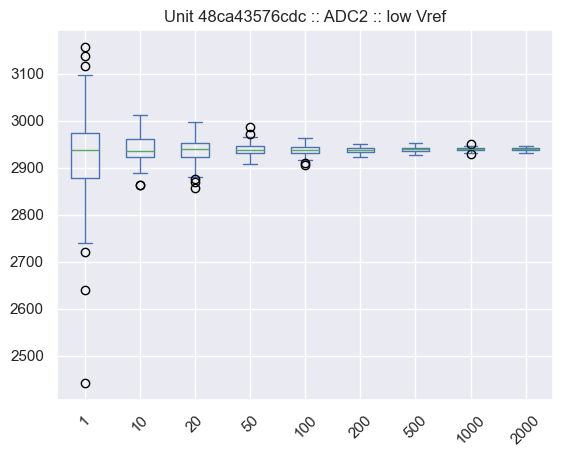

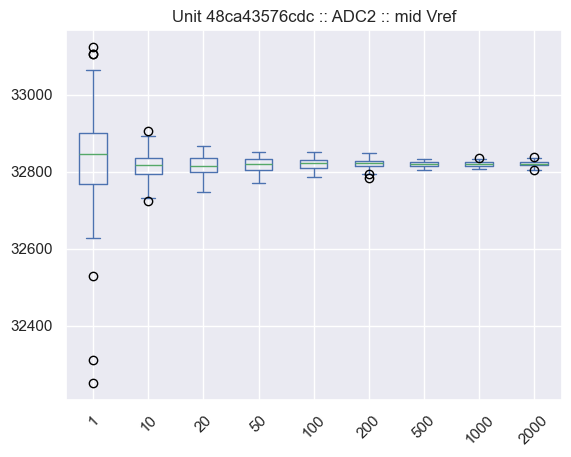

In [62]:
for name, subframe in by_qtpy_adc_vref:
    title = f"Unit {name[0]} :: {name[1]} :: {name[2]} Vref"
    boxplot = subframe.plot.box(by="Samples averaged", column="ADC code", rot=45)
    for axis in boxplot:
        axis.set_title(title)

# Evaluate how averaging impacts accuracy

## Plot the standard deviation of the data for each ADC instance

In [63]:
std_frames = []
for name, subframe in by_qtpy_adc_vref:
    title = f"Unit {name[0]} :: {name[1]} :: {name[2]} Vref"
    std_by_averages = subframe.groupby("Samples averaged")["ADC code"].std()
    qtpy_adc_vref_std = pd.DataFrame({
        "QTPy identifier": name[0],
        "ADC instance": name[1],
        "Reference voltage": name[2],
        "std": std_by_averages,
    })
    std_frames.append(qtpy_adc_vref_std)

all_std_frames = pd.concat(std_frames)
display(all_std_frames)

,QTPy identifier,ADC instance,Reference voltage,std
Samples averaged,,,,
1,24ec4a1dd628,ADC1,high,247.311209
10,24ec4a1dd628,ADC1,high,73.156469
20,24ec4a1dd628,ADC1,high,51.911068
50,24ec4a1dd628,ADC1,high,34.078946
100,24ec4a1dd628,ADC1,high,27.944733
...,...,...,...,...
100,48ca43576cdc,ADC2,mid,13.158133
200,48ca43576cdc,ADC2,mid,11.482558
500,48ca43576cdc,ADC2,mid,6.782570


In [64]:
std_bar_groups = all_std_frames.groupby(["QTPy identifier", "ADC instance", "Reference voltage"])
display(std_bar_groups.size())

QTPy identifier  ADC instance  Reference voltage
24ec4a1dd628     ADC1          high                 9
                               low                  9
                               mid                  9
                 ADC2          high                 9
                               low                  9
                               mid                  9
48ca43576cdc     ADC1          high                 9
                               low                  9
                               mid                  9
                 ADC2          high                 9
                               low                  9
                               mid                  9
dtype: int64

In [65]:
std_bars_by_qtpy_acd_vref = pd.DataFrame()
for name, subframe in std_bar_groups:
    column_name = f"Unit {name[0]} :: {name[1]} :: {name[2]} Vref"
    std_bars_by_qtpy_acd_vref[column_name] = subframe["std"]

display(std_bars_by_qtpy_acd_vref)

,Unit 24ec4a1dd628 :: ADC1 :: high Vref,Unit 24ec4a1dd628 :: ADC1 :: low Vref,Unit 24ec4a1dd628 :: ADC1 :: mid Vref,Unit 24ec4a1dd628 :: ADC2 :: high Vref,Unit 24ec4a1dd628 :: ADC2 :: low Vref,Unit 24ec4a1dd628 :: ADC2 :: mid Vref,Unit 48ca43576cdc :: ADC1 :: high Vref,Unit 48ca43576cdc :: ADC1 :: low Vref,Unit 48ca43576cdc :: ADC1 :: mid Vref,Unit 48ca43576cdc :: ADC2 :: high Vref,Unit 48ca43576cdc :: ADC2 :: low Vref,Unit 48ca43576cdc :: ADC2 :: mid Vref
Samples averaged,,,,,,,,,,,,
1,247.311209,138.023589,166.932183,130.313382,79.834601,100.467174,239.224158,131.035936,169.012057,132.140763,102.237005,139.099047
10,73.156469,47.648007,47.125418,36.319320,36.295100,36.324927,74.415938,50.543476,52.753985,45.866668,32.667991,36.028346
20,51.911068,34.152204,37.240682,32.554588,23.638268,26.327415,48.937401,32.015341,39.137302,34.829440,24.874844,29.045105
50,34.078946,21.807297,23.109077,21.996464,16.080883,17.155307,39.090800,23.903304,24.498573,23.570499,14.206670,18.054412
100,27.944733,15.385413,20.187980,15.524956,10.403550,13.808248,28.760747,17.364056,19.785814,20.594664,10.933662,13.158133
200,21.591375,12.259883,13.659150,12.915745,7.620150,10.993542,24.491163,11.914641,13.714742,18.244083,6.567712,11.482558
500,17.880549,9.652372,10.558713,10.920533,5.055289,8.129319,21.511528,9.674001,10.270285,15.070358,4.729746,6.782570
1000,15.050098,7.732661,9.553806,11.225807,3.531207,6.940489,21.737857,8.236798,7.747774,13.438678,3.798763,6.263309
2000,15.308875,7.004889,7.627921,10.018106,2.348344,6.405805,19.468694,7.132357,7.411207,13.637387,3.197553,6.170303


,Unit 24ec4a1dd628 :: ADC1 :: high Vref % change,Unit 24ec4a1dd628 :: ADC1 :: low Vref % change,Unit 24ec4a1dd628 :: ADC1 :: mid Vref % change,Unit 24ec4a1dd628 :: ADC2 :: high Vref % change,Unit 24ec4a1dd628 :: ADC2 :: low Vref % change,Unit 24ec4a1dd628 :: ADC2 :: mid Vref % change,Unit 48ca43576cdc :: ADC1 :: high Vref % change,Unit 48ca43576cdc :: ADC1 :: low Vref % change,Unit 48ca43576cdc :: ADC1 :: mid Vref % change,Unit 48ca43576cdc :: ADC2 :: high Vref % change,Unit 48ca43576cdc :: ADC2 :: low Vref % change,Unit 48ca43576cdc :: ADC2 :: mid Vref % change
Samples averaged,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,-70.419267,-65.478360,-71.769722,-72.129248,-54.537131,-63.843985,-68.892800,-61.427775,-68.786851,-65.289539,-68.046803,-74.098783
20,-29.041043,-28.323961,-20.975382,-10.365646,-34.872013,-27.522456,-34.238011,-36.657816,-25.811668,-24.063723,-23.855605,-19.382630
50,-34.351290,-36.146735,-37.946687,-32.432061,-31.970977,-34.838620,-20.120810,-25.337969,-37.403522,-32.325930,-42.887403,-37.840086
100,-18.000008,-29.448327,-12.640474,-29.420675,-35.304859,-19.510341,-26.425791,-27.357089,-19.236868,-12.625252,-23.038529,-27.119568
200,-22.735441,-20.314891,-32.340183,-16.806560,-26.754326,-20.384239,-14.845177,-31.383307,-30.683966,-11.413544,-39.931270,-12.734140
500,-17.186610,-21.268649,-22.698607,-15.447905,-33.658924,-26.053687,-12.166164,-18.805773,-25.114993,-17.395916,-27.984876,-40.931542
1000,-15.829777,-19.888485,-9.517331,2.795421,-30.148272,-14.623982,1.052131,-14.856343,-24.561255,-10.827078,-19.683570,-7.655810
2000,1.719438,-9.411667,-20.158299,-10.758259,-33.497416,-7.703833,-10.438762,-13.408625,-4.344057,1.478634,-15.826458,-1.484940


Text(0, 0.5, '% improvement in std')

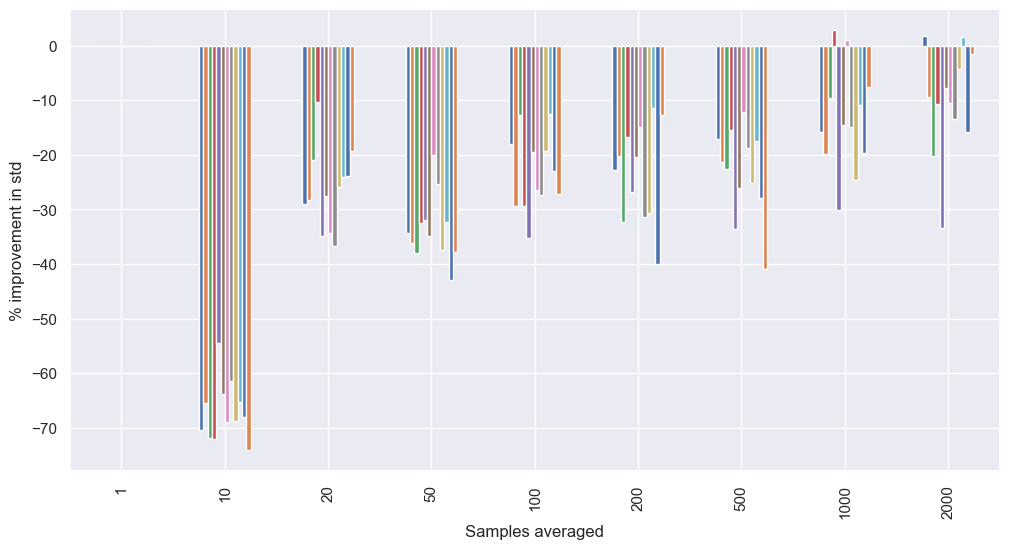

In [66]:
explore_diff = std_bars_by_qtpy_acd_vref.pct_change() * 100
explore_diff = explore_diff.rename(columns={name: f"{name} % change" for name in std_bars_by_qtpy_acd_vref.columns})
display(explore_diff)
diff_bars = explore_diff.plot.bar(figsize=(12, 6), legend=False)
diff_bars.set_ylabel("% improvement in std")

In [67]:
explore_diff[explore_diff <= -20].count(axis="columns")

Samples averaged
1        0
10      12
20      10
50      12
100      7
200      8
500      7
1000     2
2000     2
dtype: int64

Text(0, 0.5, 'ADC code std')

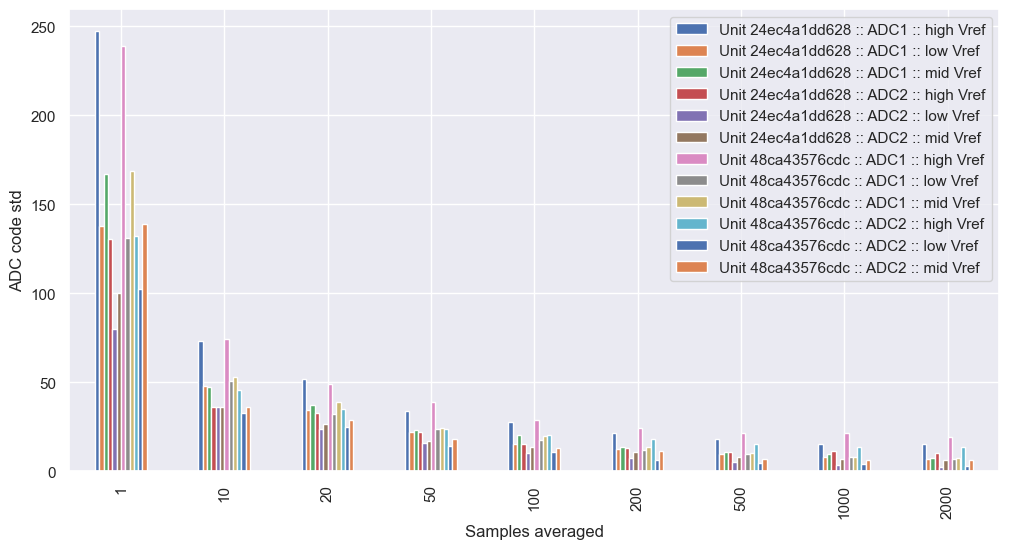

In [68]:
std_bars = std_bars_by_qtpy_acd_vref.plot.bar(figsize=(12,6))
std_bars.set_ylabel("ADC code std")
#std_bars.set_ylim(top=60)

## Plot again but scale to volts

Text(0, 0.5, 'ADC std (mV)')

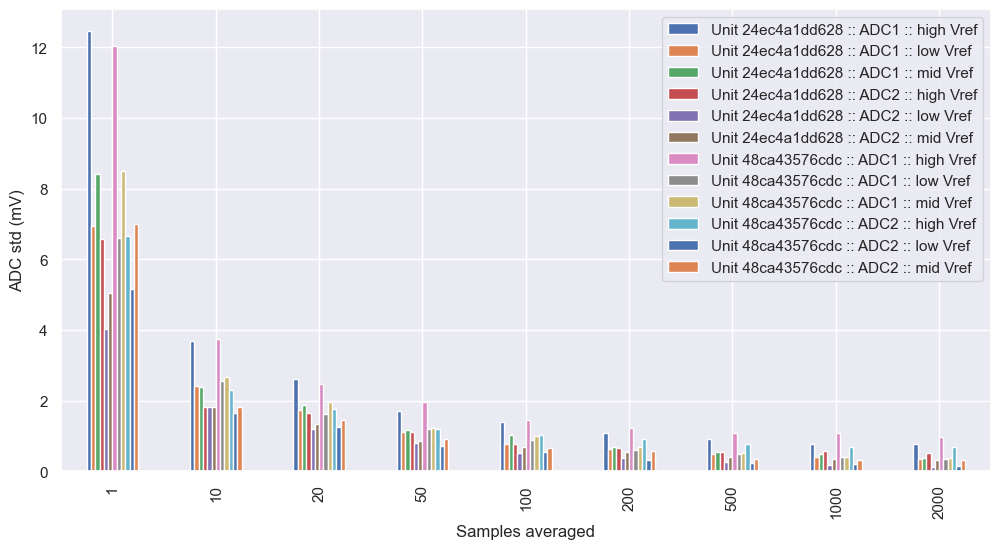

In [69]:
scaled_qtpy_adc_std = std_bars_by_qtpy_acd_vref * volts_per_LSB * 1000
scaled_std_bars = scaled_qtpy_adc_std.plot.bar(figsize=(12,6))
scaled_std_bars.set_ylabel("ADC std (mV)")
#scaled_std_bars.set_ylim(top=4)

## Choose a cut-in uncertainty of accuracy and plot statistics

In [70]:
mV_cutin = 2.0
filtered = scaled_qtpy_adc_std[scaled_qtpy_adc_std < mV_cutin]
display(filtered)

,Unit 24ec4a1dd628 :: ADC1 :: high Vref,Unit 24ec4a1dd628 :: ADC1 :: low Vref,Unit 24ec4a1dd628 :: ADC1 :: mid Vref,Unit 24ec4a1dd628 :: ADC2 :: high Vref,Unit 24ec4a1dd628 :: ADC2 :: low Vref,Unit 24ec4a1dd628 :: ADC2 :: mid Vref,Unit 48ca43576cdc :: ADC1 :: high Vref,Unit 48ca43576cdc :: ADC1 :: low Vref,Unit 48ca43576cdc :: ADC1 :: mid Vref,Unit 48ca43576cdc :: ADC2 :: high Vref,Unit 48ca43576cdc :: ADC2 :: low Vref,Unit 48ca43576cdc :: ADC2 :: mid Vref
Samples averaged,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,1.828823,1.827604,1.829106,NaN,NaN,NaN,NaN,1.644964,1.814171
20,NaN,1.719700,1.875217,1.639254,1.190281,1.325691,NaN,1.612101,1.970720,1.753802,1.252548,1.462537
50,1.716011,1.098085,1.163635,1.107610,0.809737,0.863838,1.968378,1.203627,1.233601,1.186869,0.715363,0.909112
100,1.407129,0.774717,1.016546,0.781744,0.523860,0.695301,1.448219,0.874350,0.996295,1.037024,0.550554,0.662565
200,1.087212,0.617334,0.687793,0.650359,0.383705,0.553569,1.233228,0.599950,0.690592,0.918663,0.330711,0.578193
500,0.900357,0.486036,0.531673,0.549893,0.254554,0.409344,1.083192,0.487125,0.517150,0.758853,0.238162,0.341530
1000,0.757833,0.389370,0.481072,0.565264,0.177810,0.349481,1.094588,0.414756,0.390131,0.676691,0.191283,0.315383
2000,0.770863,0.352724,0.384096,0.504452,0.118249,0.322558,0.980327,0.359143,0.373184,0.686697,0.161010,0.310699


In [71]:
count_required_to_meet_minimum_uncertainty = len(filtered.columns)
display_markdown(f"### Count required to meet minimum uncertainty == `{count_required_to_meet_minimum_uncertainty}`")

### Count required to meet minimum uncertainty == `12`

In [72]:
meets_minimum_undertainty = filtered.count(axis="columns") == count_required_to_meet_minimum_uncertainty
display(meets_minimum_undertainty)

Samples averaged
1       False
10      False
20      False
50       True
100      True
200      True
500      True
1000     True
2000     True
dtype: bool

In [73]:
lowest_average_to_meet_minimum_uncertainty = meets_minimum_undertainty.loc[meets_minimum_undertainty == True].index[0]
display_markdown(f"## Lowest average count to meet **{mV_cutin} mV** cut-in\n`{lowest_average_to_meet_minimum_uncertainty}` samples averaged")

## Lowest average count to meet **2.0 mV** cut-in
`50` samples averaged

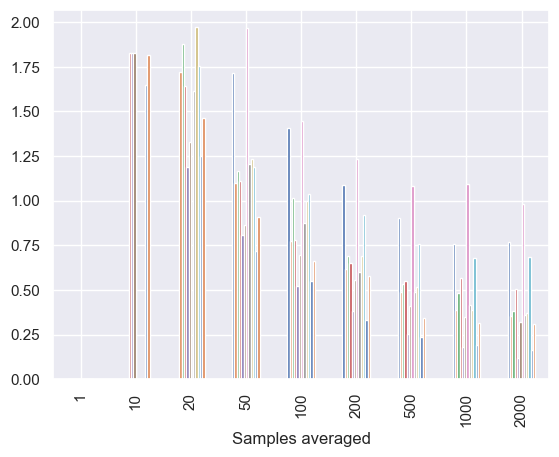

In [74]:
bars_qtpy2 = filtered.plot.bar(legend=False)

## Choose a cut-in average count and plot statistics

In [75]:
avg_count_cutin = 50
all_filtered = data_subset[(data_subset["Samples averaged"] > avg_count_cutin)]
display(all_filtered)

,QTPy channel,Samples averaged,ADC code,QTPy identifier,Reference voltage,ADC instance
32,AI0,100,2978.88,24ec4a1dd628,low,ADC2
33,AI1,100,2963.77,24ec4a1dd628,low,ADC2
34,AI2,100,2582.14,24ec4a1dd628,low,ADC1
35,AI3,100,2599.26,24ec4a1dd628,low,ADC1
36,AI4,100,2553.89,24ec4a1dd628,low,ADC1
...,...,...,...,...,...,...
12955,AI3,2000,59622.70,48ca43576cdc,high,ADC1
12956,AI4,2000,59608.90,48ca43576cdc,high,ADC1
12957,AI5,2000,59617.30,48ca43576cdc,high,ADC1
12958,AI6,2000,59615.10,48ca43576cdc,high,ADC1


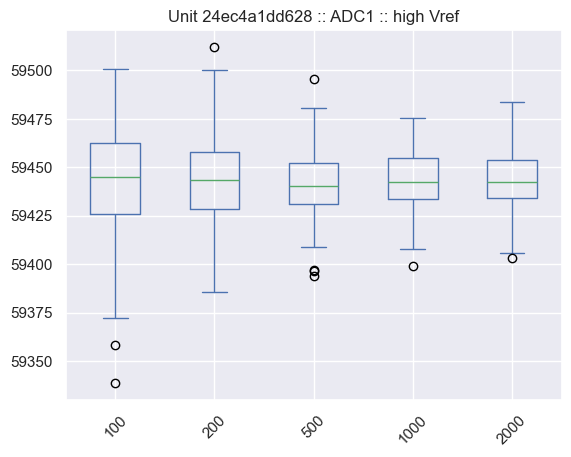

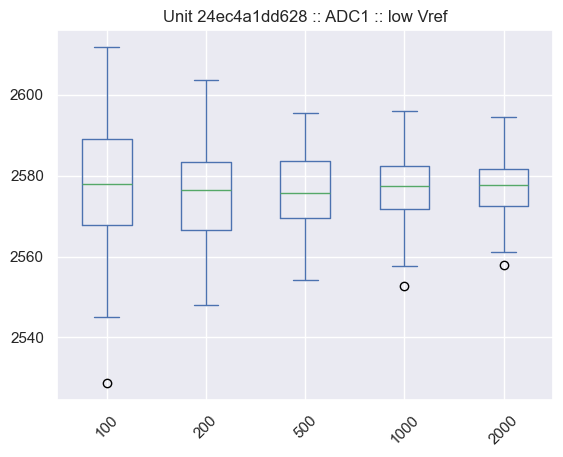

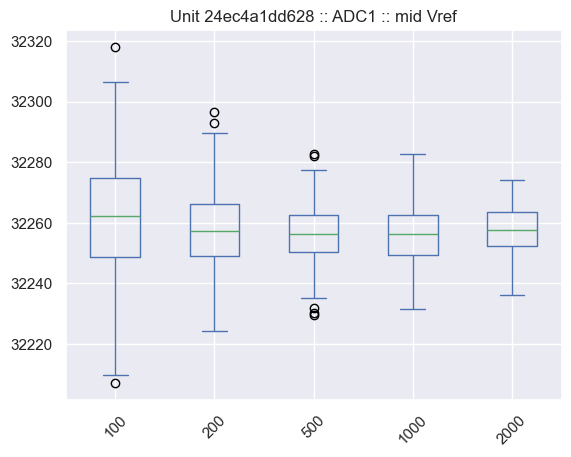

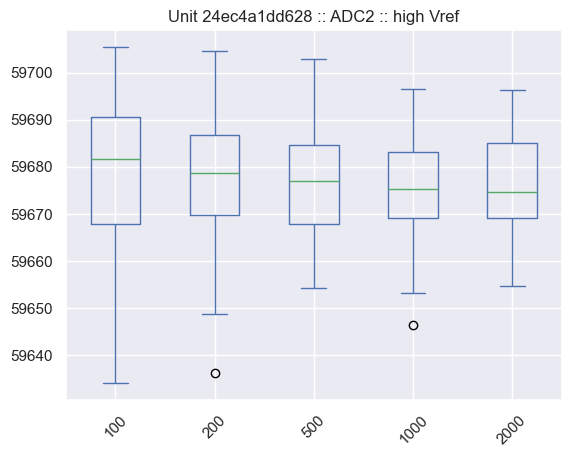

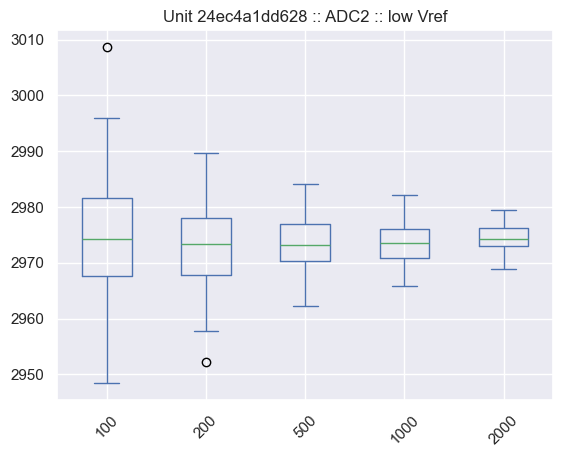

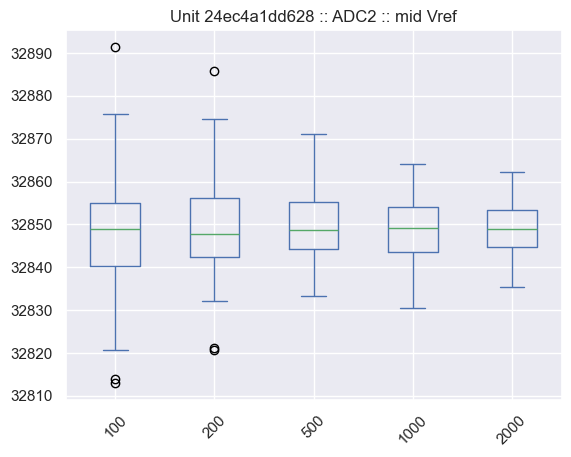

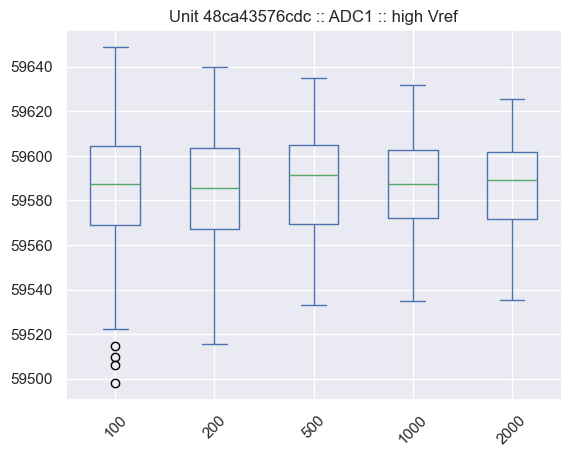

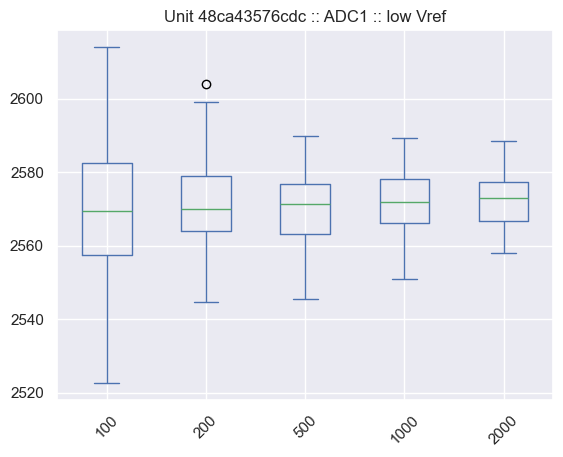

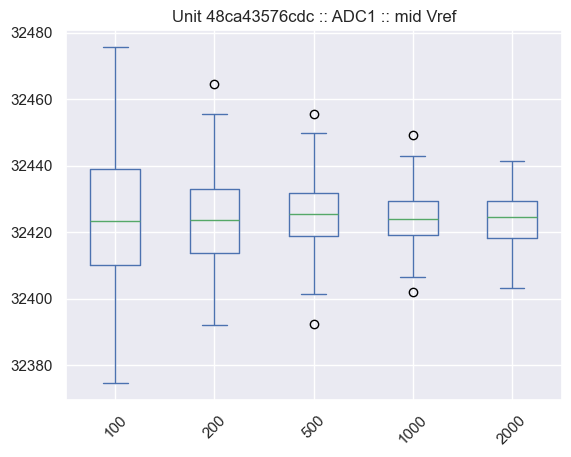

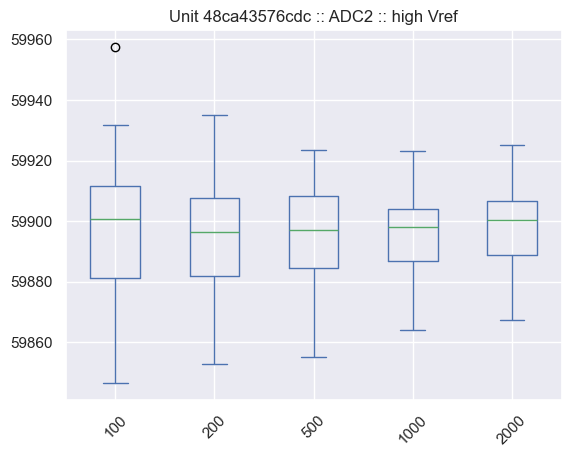

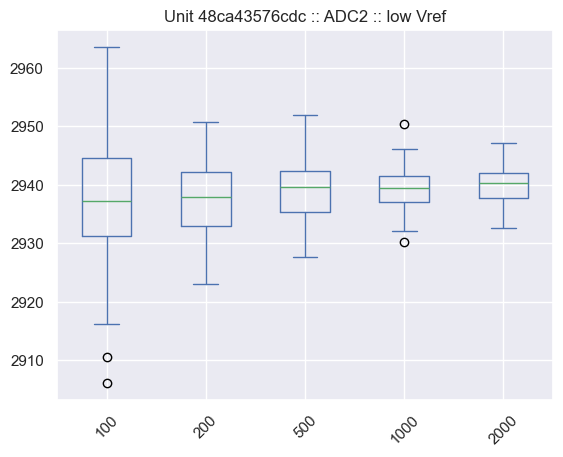

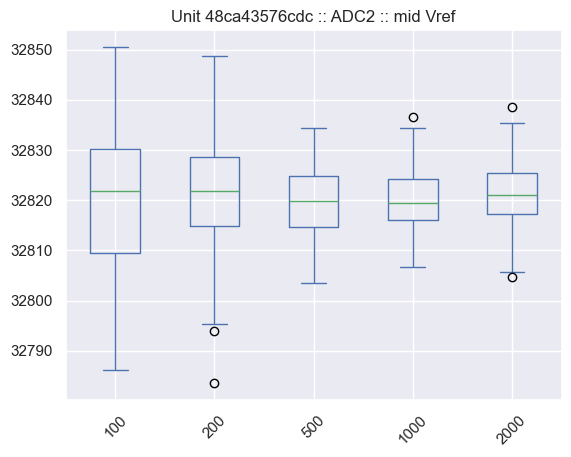

In [76]:
for name, subframe in all_filtered.groupby(["QTPy identifier", "ADC instance", "Reference voltage"]):
    title = f"Unit {name[0]} :: {name[1]} :: {name[2]} Vref"
    boxplot = subframe.plot.box(by="Samples averaged", column="ADC code", rot=45)
    for axis in boxplot:
        axis.set_title(title)